In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import intake,yaml
import intake_esm
from scipy import special
import keras
from keras.models import Model
from keras.layers import Dense, Input

from netCDF4 import Dataset
import scipy as sp
import scipy.io as sp_io
from mpl_toolkits.basemap import Basemap, cm, shiftgrid
import seaborn as sns
from matplotlib.colors import ListedColormap
colours=sns.color_palette('colorblind', 10)
my_cmap = ListedColormap(colours)

In [2]:
#%pip install git+https://github.com/jbusecke/cmip6_preprocessing.git

In [3]:
from cmip6_preprocessing.preprocessing import combined_preprocessing
from cmip6_preprocessing.preprocessing import (correct_units,rename_cmip6)

In [4]:
def pp_enso(ds):
    ds = ds.copy()   #the wrapper function makes a copy of the ds and works from this
    ds = rename_cmip6(ds)
    #ds = fix_time(ds)
    #ds = fix_units(ds)
    #ds = correct_units(ds)
    return ds

## Retrieving CESM2 data

for the other models and scenarios, please change the variable "expname_filter" and "model_filter"

In [5]:
col_url = "https://cmip6-nc.s3.us-east-2.amazonaws.com/esgf-world.json" 
col = intake.open_esm_datastore(col_url)
esmcol_data = col.esmcol_data

In [6]:
%pwd

'/home/jovyan/DNN4Cli/THOR/ApplicationOnCMIPModels/CESM2'

In [7]:
def latest_version(cat):#this function gets the latest version of our catalog
    """
    input
    cat: esmdatastore
    output
    esmdatastore with latest DRS versions
    """
    latest_cat = cat.df.sort_values(by=['version','path']).drop_duplicates(['temporal subset','model','mip_table',
                                               'institute','variable','ensemble_member',
                                               'grid_label','experiment_id'],keep='last')
    return latest_cat


In [8]:
#define location of weights file and image output here
import sys,os
wgtsdir = "/home/jovyan/DNN4Cli/ensembleMLP"
imgdirHisto = "png_historical_CESM2"
imgdir1prct = "png_1prctCO2_CESM2"
imgdirabrupt4Co2 = "png_abrupt4prctCO2_CESM2"
if(os.path.exists(wgtsdir)):
    print("weight dir exists")
else:
    sys.exit("weights directory is invalid")
if(os.path.exists(wgtsdir+'/vanillamodel_0.h5')):
    print("weight file exists")
else:
    sys.exit("weights directory is invalid:"+wgtsdir+'/vanillamodel_0.h5')   
    
if not os.path.exists(imgdirHisto):
    os.makedirs(imgdirHisto)
if not os.path.exists(imgdir1prct):
    os.makedirs(imgdir1prct)
if not os.path.exists(imgdirabrupt4Co2):
    os.makedirs(imgdirabrupt4Co2)

weight dir exists
weight file exists


## A query for all data Needed to run all the variable and experiment under CESM2

In [9]:
query_Omon_tauuo = dict(experiment_id=['abrupt-4xCO2','1pctCO2','historical'],
                 mip_table=['Omon'],
                 ensemble_member=["r1i1p1f1","r1i1p1f2"],
                 model=['CESM2'],
                 grid_label=['gn'],
                 variable=["tauuo"])
query_Omon_tauvo = dict(experiment_id=['abrupt-4xCO2','1pctCO2','historical'],
                 mip_table=['Omon'],
                 ensemble_member=["r1i1p1f1","r1i1p1f2"],
                 model=['CESM2'],
                 grid_label=['gn'],
                 variable=["tauvo"])
query_Omon_zos = dict(experiment_id=['abrupt-4xCO2','1pctCO2','historical'],
                 mip_table=['Omon'],
                 ensemble_member=["r1i1p1f1","r1i1p1f2"],
                 model=['CESM2'],
                 grid_label=['gn'],
                 variable=["zos"])
query_Ofx = dict(experiment_id=['1pctCO2','abrupt-4xCO2','historical'],
                 mip_table=['Ofx'],
                 ensemble_member=["r1i1p1f1","r1i1p1f2"],
                 model=['CESM2'],
                 grid_label=['gn'],
                 variable=["deptho"])

In [10]:
cat_Ofx = col.search(**query_Ofx) 
cat_Omon_tauuo_lat = latest_version(cat_Ofx)

In [11]:
cat_Omon_tauuo_lat

project institute  model experiment_id frequency modeling_realm mip_table  \
3   CMIP6      NCAR  CESM2    historical       NaN            NaN       Ofx   
0   CMIP6      NCAR  CESM2       1pctCO2       NaN            NaN       Ofx   
2   CMIP6      NCAR  CESM2  abrupt-4xCO2       NaN            NaN       Ofx   

  ensemble_member grid_label variable temporal subset    version  \
3        r1i1p1f1         gn   deptho             NaN  v20190308   
0        r1i1p1f1         gn   deptho             NaN  v20190425   
2        r1i1p1f1         gn   deptho             NaN  v20190927   

                                                path  
3  s3://esgf-world/CMIP6/CMIP/NCAR/CESM2/historic...  
0  s3://esgf-world/CMIP6/CMIP/NCAR/CESM2/1pctCO2/...  
2  s3://esgf-world/CMIP6/CMIP/NCAR/CESM2/abrupt-4...

In [12]:
cat_Ofx_latest = intake.open_esm_datastore(cat_Omon_tauuo_lat,esmcol_data=esmcol_data)

In [13]:
cat_Ofx_latest

In [14]:
set_dict_Ofx= cat_Ofx_latest.to_dataset_dict(storage_options={'anon':True},preprocess = pp_enso)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'project.institute.model.experiment_id.mip_table'


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'deptho' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [15]:
set_dict_Ofx.keys()

dict_keys(['CMIP6.NCAR.CESM2.1pctCO2.Ofx', 'CMIP6.NCAR.CESM2.historical.Ofx', 'CMIP6.NCAR.CESM2.abrupt-4xCO2.Ofx'])

In [16]:
xr_Ofx_Histo = set_dict_Ofx['CMIP6.NCAR.CESM2.historical.Ofx']
xr_Ofx_Histo.deptho.shape

(1, 384, 320)

In [76]:
xr_Ofx_Histo

<xarray.Dataset>
Dimensions:          (ensemble_member: 1, vertex: 4, x: 320, y: 384)
Coordinates:
    lat              (y, x) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lon              (y, x) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * y                (y) int32 1 2 3 4 5 6 7 8 ... 378 379 380 381 382 383 384
  * x                (x) int32 1 2 3 4 5 6 7 8 ... 314 315 316 317 318 319 320
  * ensemble_member  (ensemble_member) <U8 'r1i1p1f1'
Dimensions without coordinates: vertex
Data variables:
    deptho           (ensemble_member, y, x) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    lat_bounds       (y, x, vertex) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
    lon_bounds       (y, x, vertex) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
Attributes: (12/47)
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             CMIP
    case_id:                 15
    cesm_casename:           b.e21.BHIST.f09_g17.CMIP6-historical.001
    contact:                 cesm_cmip6@ucar.edu
    creation_date:           2019-01-17T00:44:19Z
    ...                      ...
    branch_time_in_parent:   [219000.]
    branch_time_in_child:    [674885.]
    branch_method:           standard
    further_info_url:        https://furtherinfo.es-doc.org/CMIP6.NCAR.CESM2....
    intake_esm_varname:      ['deptho']
    intake_esm_dataset_key:  CMIP6.NCAR.CESM2.historical.Ofx

## Saving Ofx as a an npz file

In [81]:
lat = xr_Ofx_Histo.lat_bounds

In [82]:
lon = xr_Ofx_Histo.lon_bounds

In [78]:
deptho = xr_Ofx_Histo.deptho

In [83]:
np.savez("Ofx_lat_lon_deptho.npz", lat =lat ,lon= lon, deptho = deptho)

In [79]:
cat_Omon_tauuo = col.search(**query_Omon_tauuo)
cat_Omon_tauuo_lat = latest_version(cat_Omon_tauuo)

cat_Omon_tauvo = col.search(**query_Omon_tauvo)
cat_Omon_tauvo_lat = latest_version(cat_Omon_tauvo)

cat_Omon_zos = col.search(**query_Omon_zos)
cat_Omon_zos_lat = latest_version(cat_Omon_zos)


In [80]:

cat_Omon_tauuo_latest = intake.open_esm_datastore(cat_Omon_tauuo_lat,esmcol_data=esmcol_data)
cat_Omon_tauvo_latest = intake.open_esm_datastore(cat_Omon_tauvo_lat,esmcol_data=esmcol_data)
cat_Omon_zos_latest = intake.open_esm_datastore(cat_Omon_zos_lat,esmcol_data=esmcol_data)


## Converting the catalogs into xarray datasets

In [20]:
set_dict_zos = cat_Omon_zos_latest.to_dataset_dict(cdf_kwargs={'decode_times': True,'use_cftime': True,'chunks': {'time': 20}}, storage_options={'anon':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'project.institute.model.experiment_id.mip_table'


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'zos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [21]:
set_dict_tauuo = cat_Omon_tauuo_latest.to_dataset_dict(cdf_kwargs={'decode_times': True,'use_cftime': True,'chunks': {'time': 20}}, storage_options={'anon':True})
set_dict_tauvo = cat_Omon_tauvo_latest.to_dataset_dict(cdf_kwargs={'decode_times': True,'use_cftime': True,'chunks': {'time': 20}}, storage_options={'anon':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'project.institute.model.experiment_id.mip_table'


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'tauuo' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(



--> The keys in the returned dictionary of datasets are constructed as follows:
	'project.institute.model.experiment_id.mip_table'


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'tauvo' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [22]:
list(set_dict_zos.keys())

['CMIP6.NCAR.CESM2.1pctCO2.Omon',
 'CMIP6.NCAR.CESM2.historical.Omon',
 'CMIP6.NCAR.CESM2.abrupt-4xCO2.Omon']

In [23]:
list(set_dict_tauuo.keys())

['CMIP6.NCAR.CESM2.historical.Omon',
 'CMIP6.NCAR.CESM2.1pctCO2.Omon',
 'CMIP6.NCAR.CESM2.abrupt-4xCO2.Omon']

In [24]:
list(set_dict_tauvo.keys())

['CMIP6.NCAR.CESM2.historical.Omon',
 'CMIP6.NCAR.CESM2.1pctCO2.Omon',
 'CMIP6.NCAR.CESM2.abrupt-4xCO2.Omon']

## CESM2 Historical Data for zos,tauuo, and tauvo

In [25]:
xr_zos_Histo = set_dict_zos['CMIP6.NCAR.CESM2.historical.Omon']
xr_tauuo_Histo = set_dict_tauuo['CMIP6.NCAR.CESM2.historical.Omon']
xr_tauvo_Histo = set_dict_tauvo['CMIP6.NCAR.CESM2.historical.Omon']



In [26]:
xr_zos_Histo

<xarray.Dataset>
Dimensions:          (d2: 2, ensemble_member: 1, nlat: 384, nlon: 320, time: 1980, vertices: 4)
Coordinates:
    lat              (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lon              (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * nlat             (nlat) int32 1 2 3 4 5 6 7 ... 378 379 380 381 382 383 384
  * nlon             (nlon) int32 1 2 3 4 5 6 7 ... 314 315 316 317 318 319 320
  * time             (time) object 1850-01-15 13:00:00.000007 ... 2014-12-15 ...
  * ensemble_member  (ensemble_member) <U8 'r1i1p1f1'
Dimensions without coordinates: d2, vertices
Data variables:
    zos              (ensemble_member, time, nlat, nlon) float32 dask.array<chunksize=(1, 20, 384, 320), meta=np.ndarray>
    time_bnds        (time, d2) object dask.array<chunksize=(20, 2), meta=np.ndarray>
    lat_bnds         (nlat, nlon, vertices) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
    lon_bnds         (nlat, nlon, vertices) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
Attributes: (12/47)
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             CMIP
    case_id:                 15
    cesm_casename:           b.e21.BHIST.f09_g17.CMIP6-historical.001
    contact:                 cesm_cmip6@ucar.edu
    creation_date:           2019-01-16T21:32:31Z
    ...                      ...
    branch_time_in_parent:   [219000.]
    branch_time_in_child:    [674885.]
    branch_method:           standard
    further_info_url:        https://furtherinfo.es-doc.org/CMIP6.NCAR.CESM2....
    intake_esm_varname:      ['zos']
    intake_esm_dataset_key:  CMIP6.NCAR.CESM2.historical.Omon

## CESM2 1prctCO2 Data for zos,tauuo, and tauvo

In [27]:
xr_zos_1prctCO2 = set_dict_zos['CMIP6.NCAR.CESM2.1pctCO2.Omon']
xr_tauuo_1prctCO2 = set_dict_tauuo['CMIP6.NCAR.CESM2.1pctCO2.Omon']
xr_tauvo_1prctCO2 = set_dict_tauvo['CMIP6.NCAR.CESM2.1pctCO2.Omon']

In [28]:
xr_tauuo_1prctCO2

<xarray.Dataset>
Dimensions:          (d2: 2, ensemble_member: 1, nlat: 384, nlon: 320, time: 1800, vertices: 4)
Coordinates:
    lat              (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lon              (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * nlat             (nlat) int32 1 2 3 4 5 6 7 ... 378 379 380 381 382 383 384
  * nlon             (nlon) int32 1 2 3 4 5 6 7 ... 314 315 316 317 318 319 320
  * time             (time) object 0001-01-15 12:45:00 ... 0150-12-15 12:00:00
  * ensemble_member  (ensemble_member) <U8 'r1i1p1f1'
Dimensions without coordinates: d2, vertices
Data variables:
    tauuo            (ensemble_member, time, nlat, nlon) float32 dask.array<chunksize=(1, 20, 384, 320), meta=np.ndarray>
    time_bnds        (time, d2) object dask.array<chunksize=(20, 2), meta=np.ndarray>
    lat_bnds         (nlat, nlon, vertices) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
    lon_bnds         (nlat, nlon, vertices) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
Attributes: (12/46)
    realization_index:       [1]
    model_doi_url:           https://doi.org/10.5065/D67H1H0V
    branch_time_in_child:    [0.]
    parent_time_units:       days since 0001-01-01 00:00:00
    activity_id:             CMIP
    parent_activity_id:      CMIP
    ...                      ...
    sub_experiment:          none
    frequency:               mon
    institution:             National Center for Atmospheric Research, Climat...
    table_id:                Omon
    source_id:               CESM2
    intake_esm_dataset_key:  CMIP6.NCAR.CESM2.1pctCO2.Omon

## CESM2 abrupt-4xCO2 Data for zos,tauuo, and tauvo

In [29]:
xr_zos_abrupt4prctCO2 = set_dict_zos['CMIP6.NCAR.CESM2.abrupt-4xCO2.Omon']
xr_tauuo_abrupt4prctCO2 = set_dict_tauuo['CMIP6.NCAR.CESM2.abrupt-4xCO2.Omon']
xr_tauvo_abrupt4prctCO2 = set_dict_tauvo['CMIP6.NCAR.CESM2.abrupt-4xCO2.Omon']

In [30]:
xr_tauvo_abrupt4prctCO2

<xarray.Dataset>
Dimensions:          (d2: 2, ensemble_member: 1, nlat: 384, nlon: 320, time: 11988, vertices: 4)
Coordinates:
    lat              (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lon              (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * nlat             (nlat) int32 1 2 3 4 5 6 7 ... 378 379 380 381 382 383 384
  * nlon             (nlon) int32 1 2 3 4 5 6 7 ... 314 315 316 317 318 319 320
  * time             (time) object 0001-01-15 12:45:00 ... 0999-12-15 12:00:00
  * ensemble_member  (ensemble_member) <U8 'r1i1p1f1'
Dimensions without coordinates: d2, vertices
Data variables:
    tauvo            (ensemble_member, time, nlat, nlon) float32 dask.array<chunksize=(1, 20, 384, 320), meta=np.ndarray>
    time_bnds        (time, d2) object dask.array<chunksize=(20, 2), meta=np.ndarray>
    lat_bnds         (nlat, nlon, vertices) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
    lon_bnds         (nlat, nlon, vertices) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
Attributes: (12/45)
    realization_index:       [1]
    model_doi_url:           https://doi.org/10.5065/D67H1H0V
    branch_time_in_child:    [-182500.]
    parent_time_units:       days since 0001-01-01 00:00:00
    activity_id:             CMIP
    parent_activity_id:      CMIP
    ...                      ...
    sub_experiment:          none
    frequency:               mon
    institution:             National Center for Atmospheric Research, Climat...
    table_id:                Omon
    source_id:               CESM2
    intake_esm_dataset_key:  CMIP6.NCAR.CESM2.abrupt-4xCO2.Omon

## Running CESM2 Historical

## Making some plots

/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


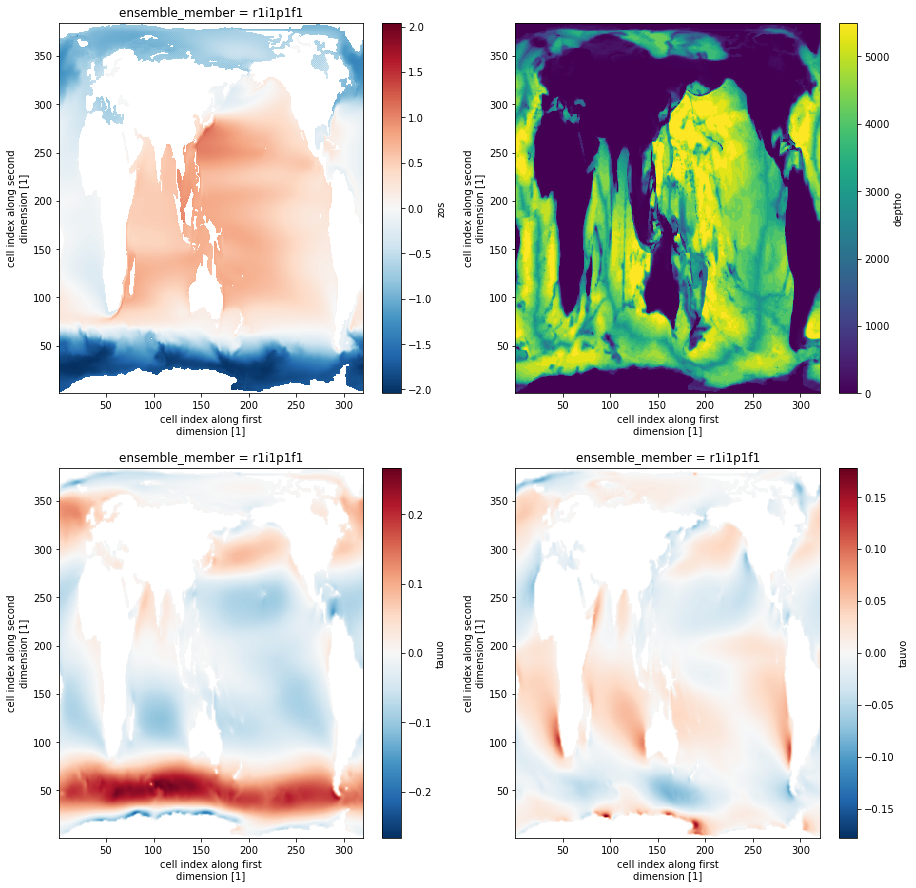

In [147]:
plt.figure(figsize=(15,15))

plt.subplot(2,2,1)
xr_zos_Histo.zos.sel(time=slice("1992", "2011")).mean(axis=1).plot()

plt.subplot(2,2,2)
xr_Ofx_Histo.deptho[:,:,:].max(axis=0).plot()

plt.subplot(2,2,3)
xr_tauuo_Histo.tauuo.sel(time=slice("1992", "2011")).mean(axis=1).plot()

plt.subplot(2,2,4)
xr_tauvo_Histo.tauvo.sel(time=slice("1992", "2011")).mean(axis=1).plot()

In [153]:
Ofx

<xarray.DataArray 'deptho' (y: 384, x: 320)>
dask.array<nanmax-aggregate, shape=(384, 320), dtype=float32, chunksize=(384, 320), chunktype=numpy.ndarray>
Coordinates:
    lat      (y, x) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lon      (y, x) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * y        (y) int32 1 2 3 4 5 6 7 8 9 ... 376 377 378 379 380 381 382 383 384
  * x        (x) int32 1 2 3 4 5 6 7 8 9 ... 312 313 314 315 316 317 318 319 320

### Preparing the features for the EnsembleMLP

In [48]:
def grad(d,y,x):
    "Returns a three point derivative."
    g0, g1 = np.gradient(d)
    grady=g0/y
    gradx=g1/x
    return grady, gradx

In [49]:
Ofx = xr_Ofx_Histo.deptho[:,:,:].max(axis=0)###This is specific to CESM2
####
lonRoll = np.roll(Ofx.lon.values, axis=1, shift=-1)
Londiff = lonRoll - Ofx.lon.values
latDiff=1.111774765625000e+05
latY=np.gradient(Ofx.lat.values, axis=0)*latDiff
lonX=np.abs(np.cos(Ofx.lat.values*np.pi/180))*latDiff*Londiff
####
Omega=7.2921e-5
f=(2*Omega*np.sin(Ofx.lat.values*np.pi/180))

In [50]:
from pickle import load
#######!!!!!! it might ask you to use scikit-learn 0.22.2.post1 !!!!!! check if you get the good .mean_ and .scale_
#(array([-2.20681035e-11,  7.85894841e-03,  1.92149912e-08,  1.38805767e-07,
#         3.96657293e+03, -1.45941754e-04,  5.42086609e-04, -1.21754470e-05]),
# array([1.46399667e-10, 7.07289355e-01, 1.89893314e-07, 4.55081599e-07,
#        1.44475515e+03, 4.87804804e-03, 4.64697134e-03, 9.54868121e-05]))
scaler = load(open('/home/jovyan/DNN4Cli/THOR/ApplicationOnCMIPModels/scaler_v1.pkl', 'rb'))

/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [51]:
scaler.mean_, scaler.scale_

(array([-2.20681035e-11,  7.85894841e-03,  1.92149912e-08,  1.38805767e-07,
         3.96657293e+03, -1.45941754e-04,  5.42086609e-04, -1.21754470e-05]),
 array([1.46399667e-10, 7.07289355e-01, 1.89893314e-07, 4.55081599e-07,
        1.44475515e+03, 4.87804804e-03, 4.64697134e-03, 9.54868121e-05]))

In [52]:
listyears = ["1872","1891","1892","1911","1912","1931","1932","1951","1952","1971","1972","1991","1992","2011"]

In [105]:
datapredicted_results_Histo = np.nan * np.zeros((7,)+Ofx.shape)

for i in range(7):
    
    print(listyears[2*i]+listyears[2*i+1])
    SSH20Mean = xr_zos_Histo.zos.isel(ensemble_member=0).sel(time=slice(listyears[2*i], listyears[2*i+1])).mean(axis=0).values
    TauUOMean = xr_tauuo_Histo.tauuo.isel(ensemble_member=0).sel(time=slice(listyears[2*i], listyears[2*i+1])).mean(axis=0).values
    TauVOMean = xr_tauvo_Histo.tauvo.isel(ensemble_member=0).sel(time=slice(listyears[2*i], listyears[2*i+1])).mean(axis=0).values

    ####
    print('Calculate grads')
    gradSSH_y, gradSSH_x = grad(SSH20Mean,latY,lonX)
    gradOfx_y, gradOfx_x = grad(Ofx,latY,lonX)
    gradUx_y, gradUx_x = grad(TauUOMean,latY,lonX)
    gradUy_y, gradUy_x = grad(TauVOMean,latY,lonX)
    ####
    print('Calculate CurlTau')
    curlTau =(gradUy_x-gradUx_y)/1032
    
    ####
    print('Calculate missindx')
    missingdataindex = np.isnan(curlTau*SSH20Mean*
                                   gradSSH_x*gradSSH_y*
                                   Ofx*gradOfx_x*
                                   gradOfx_y*f)
    ####
    print('Creating TotalDataset')
    TotalDataset = np.stack((curlTau[~missingdataindex],
                         SSH20Mean[~missingdataindex],
                         gradSSH_x[~missingdataindex],
                         gradSSH_y[~missingdataindex],
                         Ofx.values[~missingdataindex],
                         gradOfx_x[~missingdataindex],
                         gradOfx_y[~missingdataindex],
                         f[~missingdataindex]),1)
    ####
    print('NN pred')
    
    datapredicted_results_vanilla_ensemble = np.nan * np.zeros((50,TotalDataset.shape[0],6))

    for j in range(50):
        I1 = Input(shape=(8,)) 
        h1 = Dense(24, activation='tanh')(I1)
        h1 = Dense(24, activation='tanh')(h1)
        h1 = Dense(16, activation='tanh')(h1)
        h1 = Dense(16, activation='tanh')(h1)
        Output = Dense(6, activation='softmax')(h1)
        vanillamodel = Model(I1, Output)
        vanillamodel.load_weights(wgtsdir+'/vanillamodel_'+str(j)+'.h5') ###path in github repo
        datapredicted = vanillamodel.predict(scaler.transform(TotalDataset))#a1r
        datapredicted_results_vanilla_ensemble[j,...] = datapredicted
        
    tmpMean = np.mean(datapredicted_results_vanilla_ensemble,0)
    tmpSoftmax = special.softmax(tmpMean,1)
    datapredicted_results_Histo[i,:,:][~missingdataindex] = np.argmax(tmpSoftmax, 1)

    
np.save('/home/jovyan/DNN4Cli/THOR/ApplicationOnCMIPModels/CESM2/CESM2-Historical-198701-201112-EnsembleMLP.npy',datapredicted_results_Histo)
    

18721891


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Calculate grads
Calculate CurlTau
Calculate missindx
Creating TotalDataset
NN pred
18921911


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Calculate grads
Calculate CurlTau
Calculate missindx
Creating TotalDataset
NN pred
19121931


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Calculate grads
Calculate CurlTau
Calculate missindx
Creating TotalDataset
NN pred
19321951


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Calculate grads
Calculate CurlTau
Calculate missindx
Creating TotalDataset
NN pred
19521971


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Calculate grads
Calculate CurlTau
Calculate missindx
Creating TotalDataset
NN pred
19721991


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Calculate grads
Calculate CurlTau
Calculate missindx
Creating TotalDataset
NN pred
19922011


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Calculate grads
Calculate CurlTau
Calculate missindx
Creating TotalDataset
NN pred


In [106]:
datapredicted_results_Histo.shape

(7, 384, 320)

In [54]:
from matplotlib.colors import ListedColormap
mycmap = ListedColormap(['royalblue', 'cyan','yellow', 'orange', 'magenta', 'red'])

In [55]:
ecco_label = np.load('/home/jovyan/DNN4Cli/THOR/ApplicationOnCMIPModels/eccolabel.npy')

Text(0.5, 1.0, 'ECCO regimes 1992-2011 (Historical)')

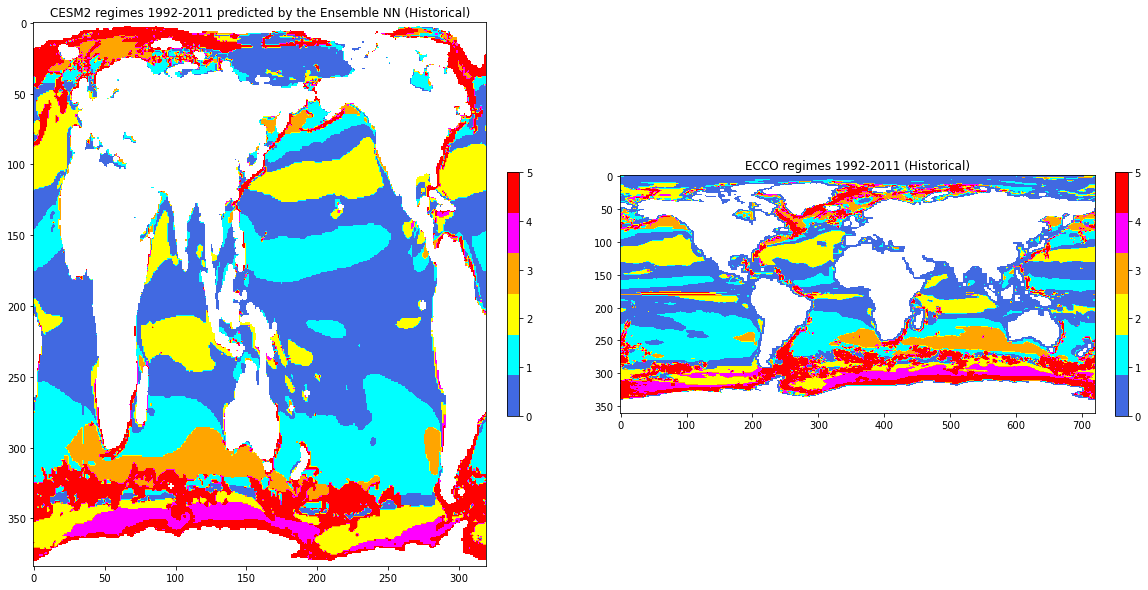

In [112]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.imshow(datapredicted_results_Histo[-1,:,:][::-1,:], cmap=mycmap)
plt.colorbar(fraction=0.024, pad=0.04)
plt.title('CESM2 regimes 1992-2011 predicted by the Ensemble NN (Historical)')

plt.subplot(1,2,2)
plt.imshow(ecco_label[::-1,:], cmap=mycmap)
plt.colorbar(fraction=0.024, pad=0.04)
plt.title('ECCO regimes 1992-2011 (Historical)')

# Save the images for the 20 years chunks

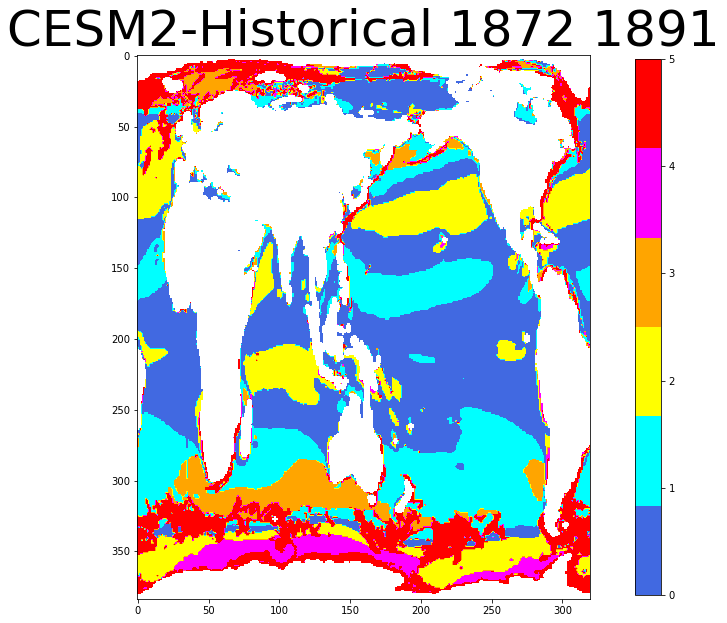

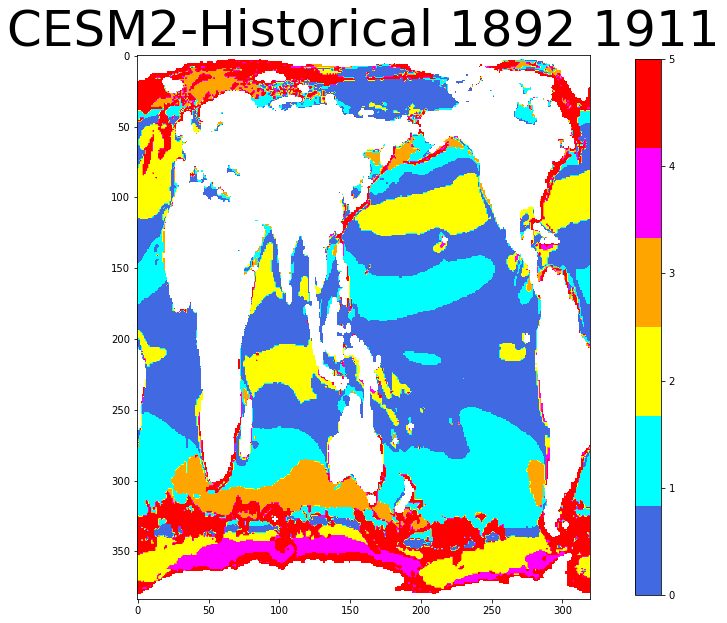

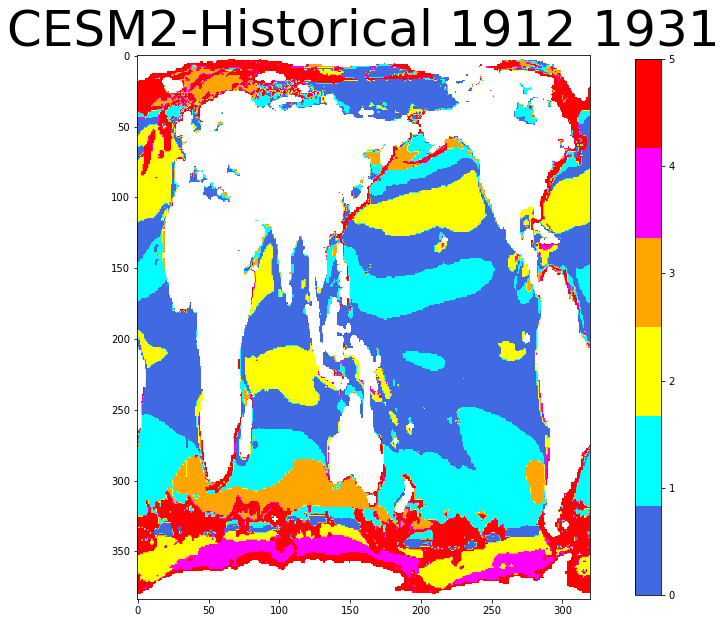

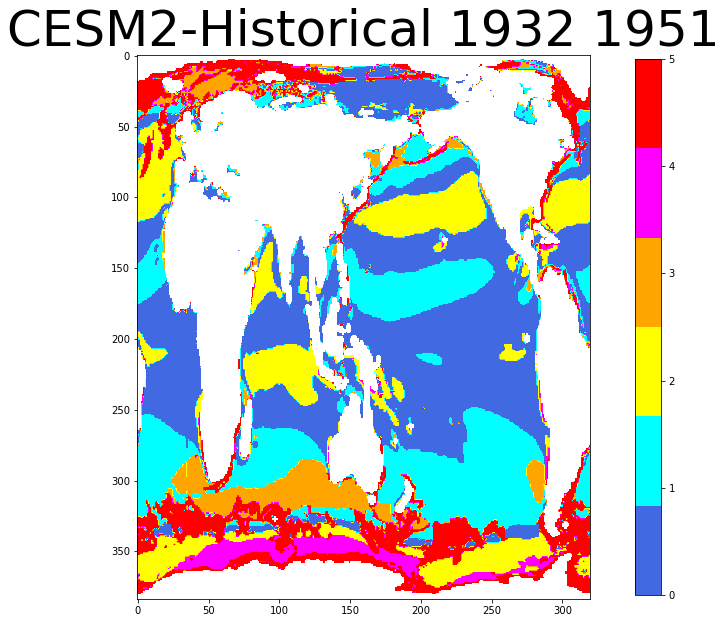

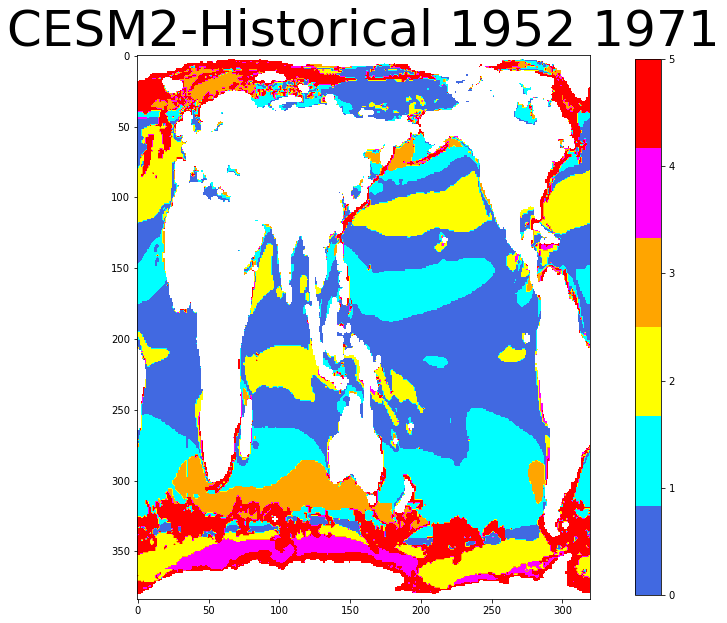

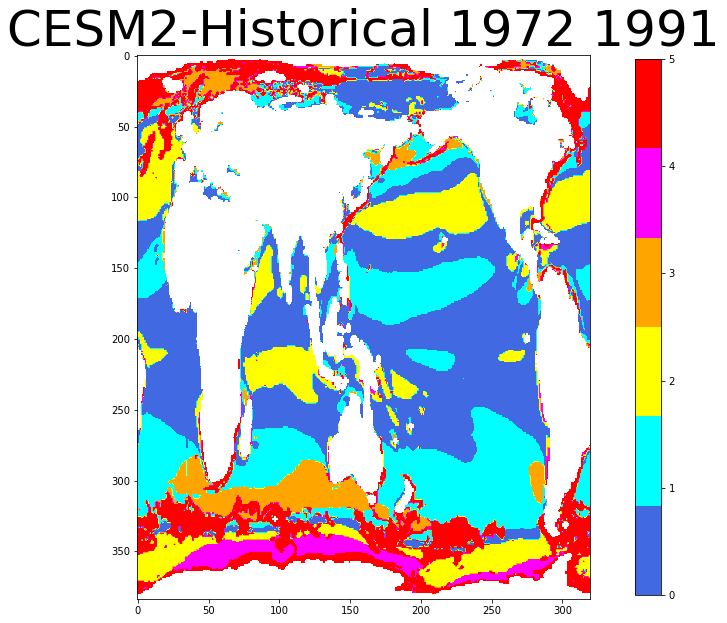

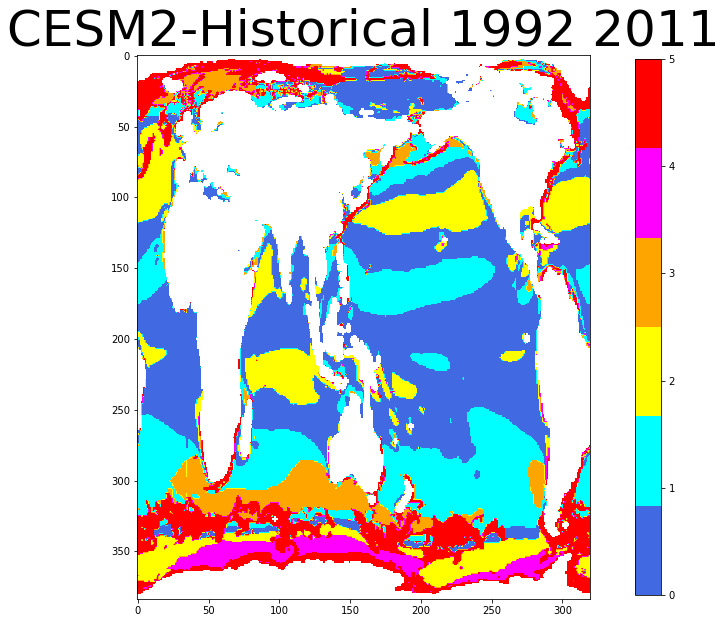

In [116]:
for i in range(7):
    plt.figure(figsize=(20,10))
    #plt.subplot(1,2,1)
    plt.imshow(datapredicted_results_Histo[i,:,:][::-1,:], cmap=mycmap)
    plt.colorbar(fraction=0.024, pad=0.04)
    plt.title('CESM2-Historical '+str(listyears[2*i])+' '+str(listyears[2*i+1]), fontsize=50)
    plt.savefig('/home/jovyan/DNN4Cli/THOR/ApplicationOnCMIPModels/CESM2/png_historical_CESM2/'+str(listyears[2*i])+str(listyears[2*i+1])+'.png')

## create a gif

In [117]:
import os
import imageio

png_dir = 'png_historical_CESM2/'
images = []
for file_name in sorted(os.listdir(png_dir)):
    if file_name.endswith('.png'):
        file_path = os.path.join(png_dir, file_name)
        images.append(imageio.imread(file_path))
imageio.mimsave('png_historical_CESM2/CESM2-png_Historical.gif', images, fps=1)

## Running CESM2 1%xCO2

## Making some  plots

/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


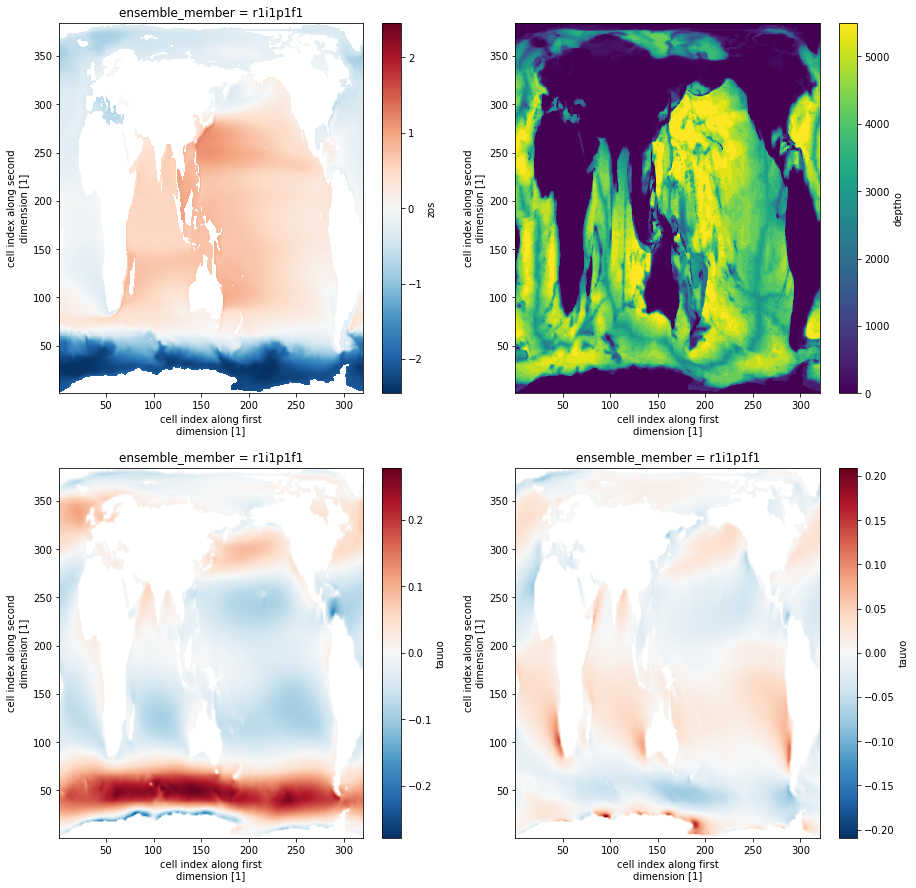

In [39]:
#sel(time=slice("1992", "2011")) I removed the date slice because it was gving me an empty plot. This is specific to 1prctCO2
plt.figure(figsize=(15,15))

plt.subplot(2,2,1)
xr_zos_1prctCO2.zos.sel(time=slice("0131", "0150")).mean(axis=1).plot()

plt.subplot(2,2,2)
xr_Ofx_Histo.deptho[:,:,:].max(axis=0).plot()

plt.subplot(2,2,3)
xr_tauuo_1prctCO2.tauuo.sel(time=slice("0131", "0150")).mean(axis=1).plot()

plt.subplot(2,2,4)
xr_tauvo_1prctCO2.tauvo.sel(time=slice("0131", "0150")).mean(axis=1).plot()

In [32]:
xr_zos_1prctCO2.zos.sel(time=slice("1992", "2011")).mean(axis=1)

<xarray.DataArray 'zos' (ensemble_member: 1, nlat: 384, nlon: 320)>
dask.array<mean_agg-aggregate, shape=(1, 384, 320), dtype=float32, chunksize=(1, 384, 320), chunktype=numpy.ndarray>
Coordinates:
    lat              (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lon              (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * nlat             (nlat) int32 1 2 3 4 5 6 7 ... 378 379 380 381 382 383 384
  * nlon             (nlon) int32 1 2 3 4 5 6 7 ... 314 315 316 317 318 319 320
  * ensemble_member  (ensemble_member) <U8 'r1i1p1f1'

In [38]:
xr_zos_1prctCO2.zos.time.to_dataframe()

time
time                                    
0001-01-15 12:45:00  0001-01-15 12:45:00
0001-02-14 00:00:00  0001-02-14 00:00:00
0001-03-15 12:00:00  0001-03-15 12:00:00
0001-04-15 00:00:00  0001-04-15 00:00:00
0001-05-15 12:00:00  0001-05-15 12:00:00
...                                  ...
0150-08-15 12:00:00  0150-08-15 12:00:00
0150-09-15 00:00:00  0150-09-15 00:00:00
0150-10-15 12:00:00  0150-10-15 12:00:00
0150-11-15 00:00:00  0150-11-15 00:00:00
0150-12-15 12:00:00  0150-12-15 12:00:00

[1800 rows x 1 columns]

## Predicting 1prctCO2...

In [45]:
listyears1prct = ["0011","0030","0031","0050","0051","0070","0071","0090","0091","0110","0111","0130","0131","0150"]

In [46]:
datapredicted_results_1prctCO2 = np.nan * np.zeros((7,)+Ofx.shape)

for i in range(7):
    
    print(listyears1prct[2*i]+listyears1prct[2*i+1])
    SSH20Mean = xr_zos_1prctCO2.zos.isel(ensemble_member=0).sel(time=slice(listyears1prct[2*i], listyears1prct[2*i+1])).mean(axis=0).values
    TauUOMean = xr_tauuo_1prctCO2.tauuo.isel(ensemble_member=0).sel(time=slice(listyears1prct[2*i], listyears1prct[2*i+1])).mean(axis=0).values
    TauVOMean = xr_tauvo_1prctCO2.tauvo.isel(ensemble_member=0).sel(time=slice(listyears1prct[2*i], listyears1prct[2*i+1])).mean(axis=0).values

    ####
    print('Calculate grads')
    gradSSH_y, gradSSH_x = grad(SSH20Mean,latY,lonX)
    gradOfx_y, gradOfx_x = grad(Ofx,latY,lonX)
    gradUx_y, gradUx_x = grad(TauUOMean,latY,lonX)
    gradUy_y, gradUy_x = grad(TauVOMean,latY,lonX)
    ####
    print('Calculate CurlTau')
    curlTau =(gradUy_x-gradUx_y)/1032
    
    ####
    print('Calculate missindx')
    missingdataindex = np.isnan(curlTau*SSH20Mean*
                                   gradSSH_x*gradSSH_y*
                                   Ofx*gradOfx_x*
                                   gradOfx_y*f)
    ####
    print('Creating TotalDataset')
    TotalDataset = np.stack((curlTau[~missingdataindex],
                         SSH20Mean[~missingdataindex],
                         gradSSH_x[~missingdataindex],
                         gradSSH_y[~missingdataindex],
                         Ofx.values[~missingdataindex],
                         gradOfx_x[~missingdataindex],
                         gradOfx_y[~missingdataindex],
                         f[~missingdataindex]),1)
    ####
    print('NN pred')
    
    datapredicted_results_vanilla_ensemble = np.nan * np.zeros((50,TotalDataset.shape[0],6))

    for j in range(50):
        I1 = Input(shape=(8,)) 
        h1 = Dense(24, activation='tanh')(I1)
        h1 = Dense(24, activation='tanh')(h1)
        h1 = Dense(16, activation='tanh')(h1)
        h1 = Dense(16, activation='tanh')(h1)
        Output = Dense(6, activation='softmax')(h1)
        vanillamodel = Model(I1, Output)
        vanillamodel.load_weights(wgtsdir+'/vanillamodel_'+str(j)+'.h5') ###path in github repo
        datapredicted = vanillamodel.predict(scaler.transform(TotalDataset))#a1r
        datapredicted_results_vanilla_ensemble[j,...] = datapredicted
        
    tmpMean = np.mean(datapredicted_results_vanilla_ensemble,0)
    tmpSoftmax = special.softmax(tmpMean,1)
    datapredicted_results_1prctCO2[i,:,:][~missingdataindex] = np.argmax(tmpSoftmax, 1)

    
np.save('/home/jovyan/DNN4Cli/THOR/ApplicationOnCMIPModels/CESM2/CESM2-1prctCO2-198701-201112-EnsembleMLP.npy',datapredicted_results_1prctCO2)
    

00110030


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Calculate grads
Calculate CurlTau
Calculate missindx
Creating TotalDataset
NN pred
00310050


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Calculate grads
Calculate CurlTau
Calculate missindx
Creating TotalDataset
NN pred
00510070


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Calculate grads
Calculate CurlTau
Calculate missindx
Creating TotalDataset
NN pred
00710090


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Calculate grads
Calculate CurlTau
Calculate missindx
Creating TotalDataset
NN pred
00910110


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Calculate grads
Calculate CurlTau
Calculate missindx
Creating TotalDataset
NN pred
01110130


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Calculate grads
Calculate CurlTau
Calculate missindx
Creating TotalDataset
NN pred
01310150


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Calculate grads
Calculate CurlTau
Calculate missindx
Creating TotalDataset
NN pred


Text(0.5, 1.0, 'ECCO regimes 0131-0150 (1prctCO2)')

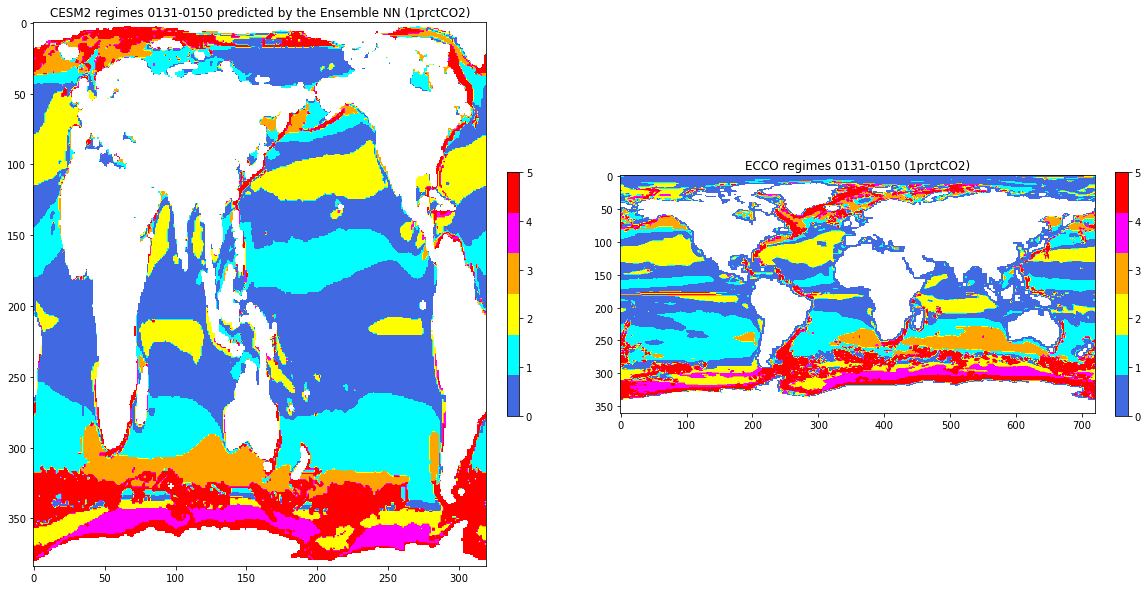

In [56]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.imshow(datapredicted_results_1prctCO2[-1,:,:][::-1,:], cmap=mycmap)
plt.colorbar(fraction=0.024, pad=0.04)
plt.title('CESM2 regimes 0131-0150 predicted by the Ensemble NN (1prctCO2)')

plt.subplot(1,2,2)
plt.imshow(ecco_label[::-1,:], cmap=mycmap)
plt.colorbar(fraction=0.024, pad=0.04)
plt.title('ECCO regimes 0131-0150 (1prctCO2)')

# Save the images for the 20 years chunks

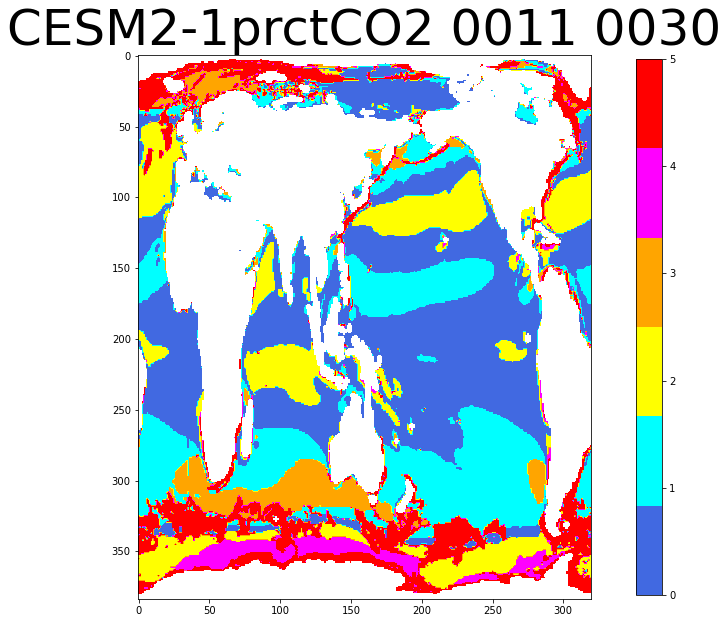

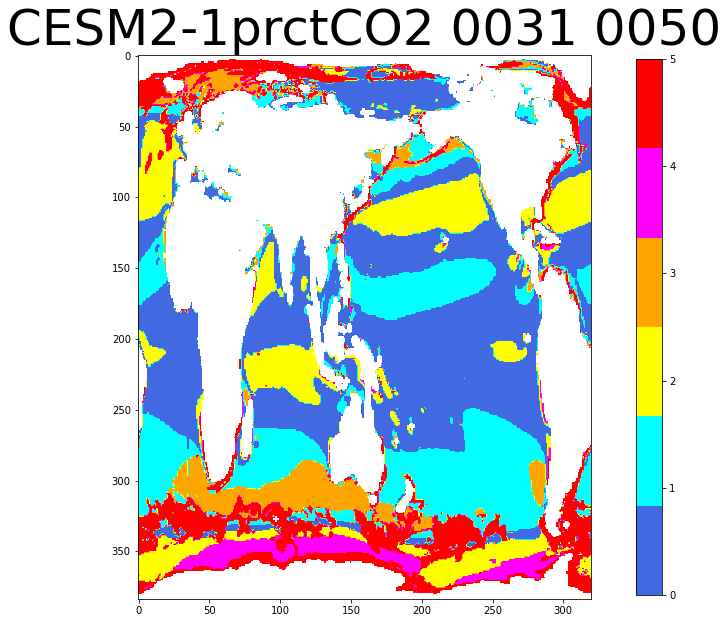

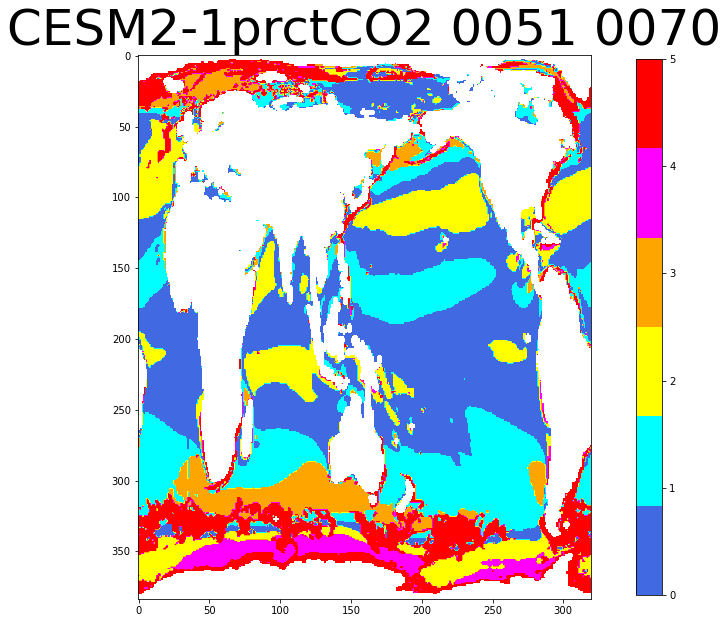

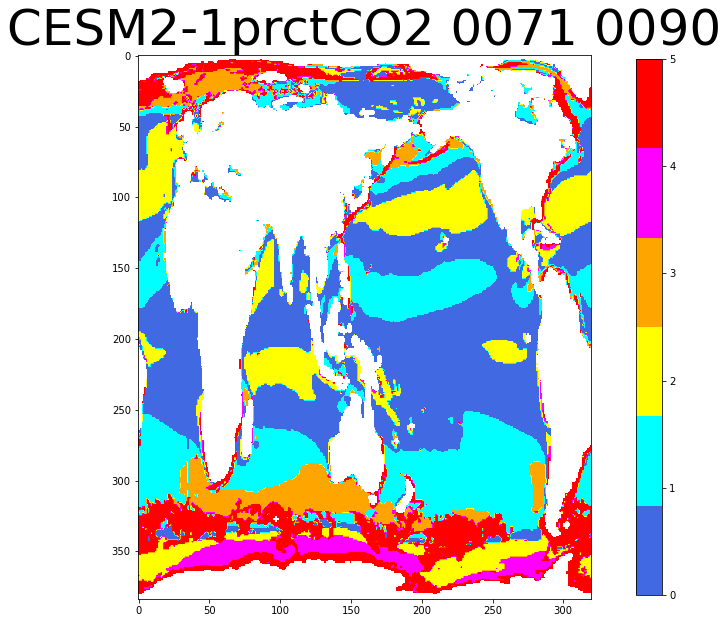

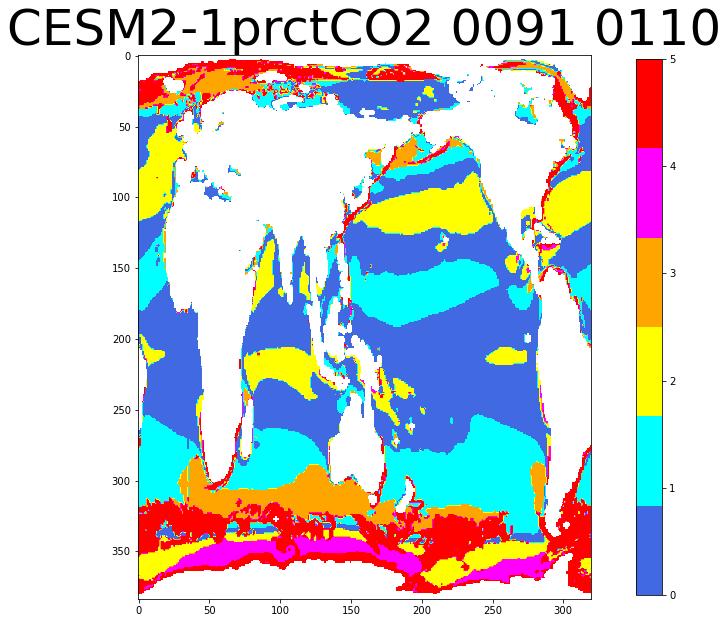

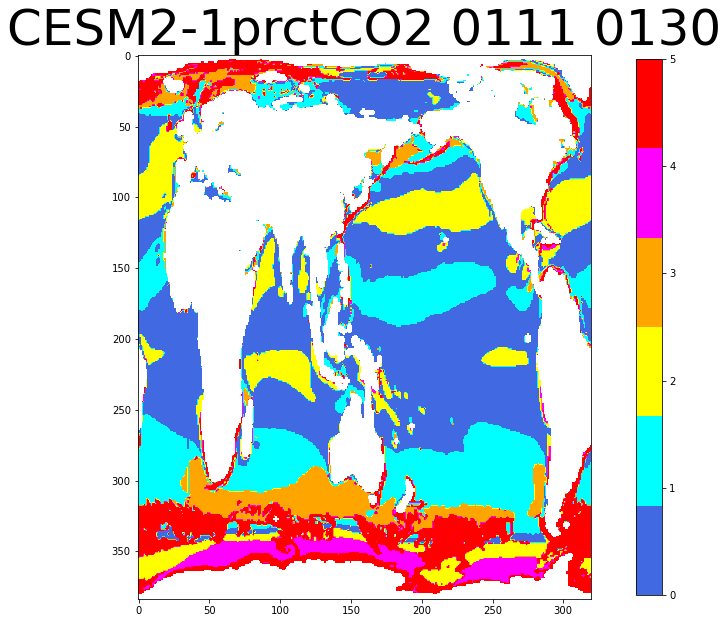

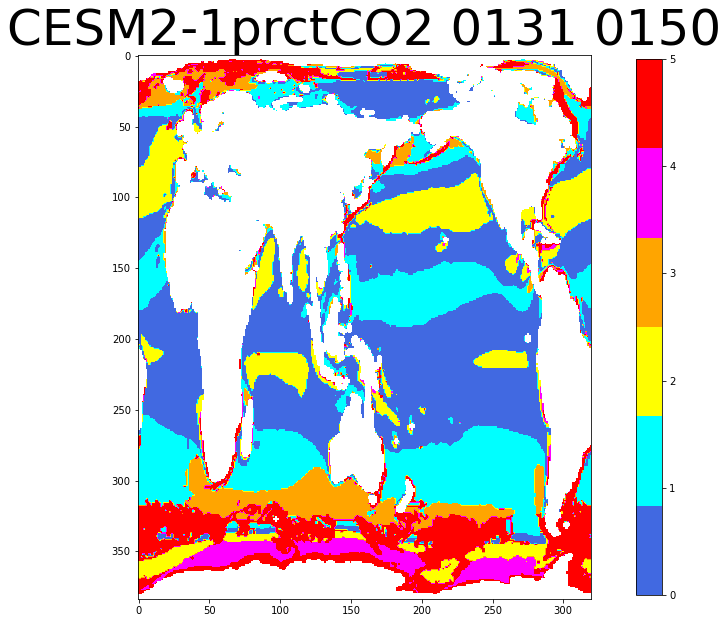

In [60]:
for i in range(7):
    plt.figure(figsize=(20,10))
    #plt.subplot(1,2,1)
    plt.imshow(datapredicted_results_1prctCO2[i,:,:][::-1,:], cmap=mycmap)
    plt.colorbar(fraction=0.024, pad=0.04)
    plt.title('CESM2-1prctCO2 '+str(listyears1prct[2*i])+' '+str(listyears1prct[2*i+1]), fontsize=50)
    plt.savefig('/home/jovyan/DNN4Cli/THOR/ApplicationOnCMIPModels/CESM2/png_1prctCO2_CESM2/'+str(listyears[2*i])+str(listyears[2*i+1])+'.png')

## create a gif

In [61]:
import os
import imageio

png_dir = 'png_1prctCO2_CESM2/'
images = []
for file_name in sorted(os.listdir(png_dir)):
    if file_name.endswith('.png'):
        file_path = os.path.join(png_dir, file_name)
        images.append(imageio.imread(file_path))
imageio.mimsave('png_1prctCO2_CESM2/CESM2-png_1prctCO2.gif', images, fps=1)

## Running abrupt4xCO2

In [62]:
xr_zos_abrupt4prctCO2.zos.time.to_dataframe()

time
time                                    
0001-01-15 12:45:00  0001-01-15 12:45:00
0001-02-14 00:00:00  0001-02-14 00:00:00
0001-03-15 12:00:00  0001-03-15 12:00:00
0001-04-15 00:00:00  0001-04-15 00:00:00
0001-05-15 12:00:00  0001-05-15 12:00:00
...                                  ...
0999-08-15 12:00:00  0999-08-15 12:00:00
0999-09-15 00:00:00  0999-09-15 00:00:00
0999-10-15 12:00:00  0999-10-15 12:00:00
0999-11-15 00:00:00  0999-11-15 00:00:00
0999-12-15 12:00:00  0999-12-15 12:00:00

[11988 rows x 1 columns]

## Making some plots

In [63]:
xr_zos_1prctCO2.zos.sel(time=slice("1992", "2011")).mean(axis=1)

<xarray.DataArray 'zos' (ensemble_member: 1, nlat: 384, nlon: 320)>
dask.array<mean_agg-aggregate, shape=(1, 384, 320), dtype=float32, chunksize=(1, 384, 320), chunktype=numpy.ndarray>
Coordinates:
    lat              (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lon              (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * nlat             (nlat) int32 1 2 3 4 5 6 7 ... 378 379 380 381 382 383 384
  * nlon             (nlon) int32 1 2 3 4 5 6 7 ... 314 315 316 317 318 319 320
  * ensemble_member  (ensemble_member) <U8 'r1i1p1f1'

/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


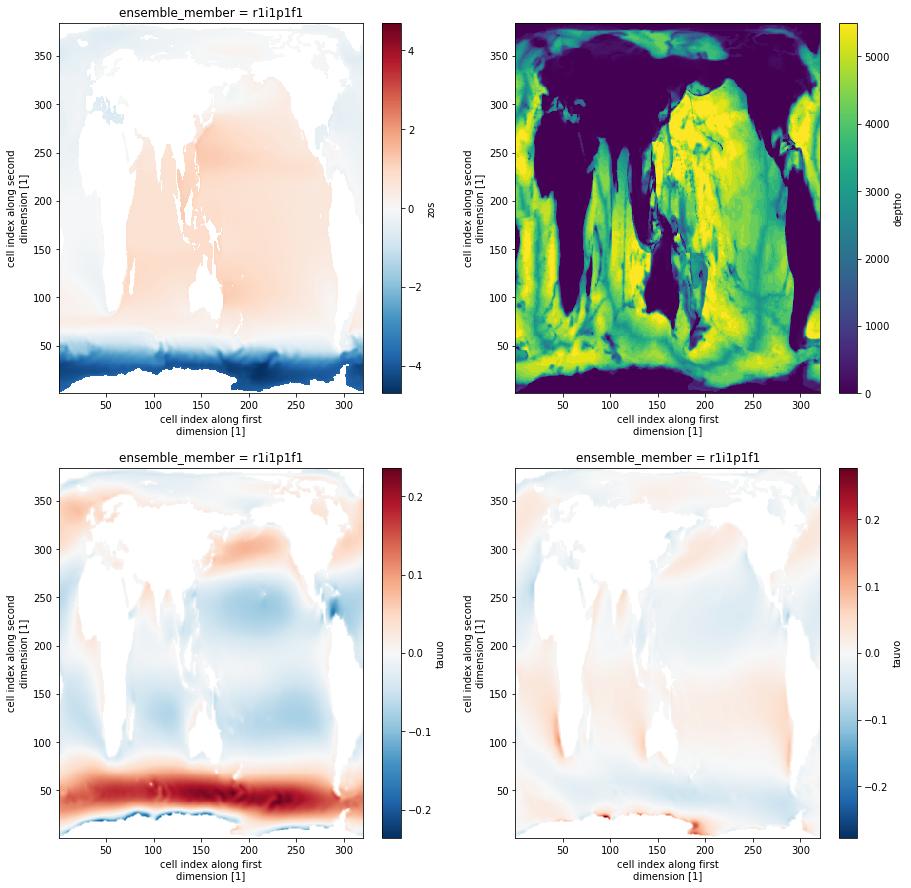

In [64]:
#sel(time=slice("1992", "2011")) I removed the date slice because it was gving me an empty plot. This is specific to 1prctCO2
plt.figure(figsize=(15,15))

plt.subplot(2,2,1)
xr_zos_abrupt4prctCO2.zos.sel(time=slice("0980","0999")).mean(axis=1).plot()

plt.subplot(2,2,2)
xr_Ofx_Histo.deptho[:,:,:].max(axis=0).plot()

plt.subplot(2,2,3)
xr_tauuo_abrupt4prctCO2.tauuo.sel(time=slice("0980","0999")).mean(axis=1).plot()

plt.subplot(2,2,4)
xr_tauvo_abrupt4prctCO2.tauvo.sel(time=slice("0980","0999")).mean(axis=1).plot()

## Predicting abrupt-4xCO2...

In [66]:
listyears4abruptprct = ["0860","0879","0880","0899","0900","0919","0920","0939","0940","0959","0960","0979","0980","0999"]

In [67]:
datapredicted_results_abrupt4CO2 = np.nan * np.zeros((7,)+Ofx.shape)

for i in range(7):
    
    print(listyears1prct[2*i]+listyears1prct[2*i+1])
    SSH20Mean = xr_zos_abrupt4prctCO2.zos.isel(ensemble_member=0).sel(time=slice(listyears4abruptprct[2*i], listyears4abruptprct[2*i+1])).mean(axis=0).values
    TauUOMean = xr_tauuo_abrupt4prctCO2.tauuo.isel(ensemble_member=0).sel(time=slice(listyears4abruptprct[2*i], listyears4abruptprct[2*i+1])).mean(axis=0).values
    TauVOMean = xr_tauvo_abrupt4prctCO2.tauvo.isel(ensemble_member=0).sel(time=slice(listyears4abruptprct[2*i], listyears4abruptprct[2*i+1])).mean(axis=0).values

    ####
    print('Calculate grads')
    gradSSH_y, gradSSH_x = grad(SSH20Mean,latY,lonX)
    gradOfx_y, gradOfx_x = grad(Ofx,latY,lonX)
    gradUx_y, gradUx_x = grad(TauUOMean,latY,lonX)
    gradUy_y, gradUy_x = grad(TauVOMean,latY,lonX)
    ####
    print('Calculate CurlTau')
    curlTau =(gradUy_x-gradUx_y)/1032
    
    ####
    print('Calculate missindx')
    missingdataindex = np.isnan(curlTau*SSH20Mean*
                                   gradSSH_x*gradSSH_y*
                                   Ofx*gradOfx_x*
                                   gradOfx_y*f)
    ####
    print('Creating TotalDataset')
    TotalDataset = np.stack((curlTau[~missingdataindex],
                         SSH20Mean[~missingdataindex],
                         gradSSH_x[~missingdataindex],
                         gradSSH_y[~missingdataindex],
                         Ofx.values[~missingdataindex],
                         gradOfx_x[~missingdataindex],
                         gradOfx_y[~missingdataindex],
                         f[~missingdataindex]),1)
    ####
    print('NN pred')
    
    datapredicted_results_vanilla_ensemble = np.nan * np.zeros((50,TotalDataset.shape[0],6))

    for j in range(50):
        I1 = Input(shape=(8,)) 
        h1 = Dense(24, activation='tanh')(I1)
        h1 = Dense(24, activation='tanh')(h1)
        h1 = Dense(16, activation='tanh')(h1)
        h1 = Dense(16, activation='tanh')(h1)
        Output = Dense(6, activation='softmax')(h1)
        vanillamodel = Model(I1, Output)
        vanillamodel.load_weights(wgtsdir+'/vanillamodel_'+str(j)+'.h5') ###path in github repo
        datapredicted = vanillamodel.predict(scaler.transform(TotalDataset))#a1r
        datapredicted_results_vanilla_ensemble[j,...] = datapredicted
        
    tmpMean = np.mean(datapredicted_results_vanilla_ensemble,0)
    tmpSoftmax = special.softmax(tmpMean,1)
    datapredicted_results_abrupt4CO2[i,:,:][~missingdataindex] = np.argmax(tmpSoftmax, 1)

    
np.save('/home/jovyan/DNN4Cli/THOR/ApplicationOnCMIPModels/CESM2/CESM2-abrupt4CO2-198701-201112-EnsembleMLP.npy',datapredicted_results_abrupt4CO2)
    

00110030


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Calculate grads
Calculate CurlTau
Calculate missindx
Creating TotalDataset
NN pred
00310050


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Calculate grads
Calculate CurlTau
Calculate missindx
Creating TotalDataset
NN pred
00510070


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Calculate grads
Calculate CurlTau
Calculate missindx
Creating TotalDataset
NN pred
00710090


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Calculate grads
Calculate CurlTau
Calculate missindx
Creating TotalDataset
NN pred
00910110


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Calculate grads
Calculate CurlTau
Calculate missindx
Creating TotalDataset
NN pred
01110130


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Calculate grads
Calculate CurlTau
Calculate missindx
Creating TotalDataset
NN pred
01310150


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Calculate grads
Calculate CurlTau
Calculate missindx
Creating TotalDataset
NN pred


Text(0.5, 1.0, 'ECCO regimes 0131-0150 (abrupt4CO2)')

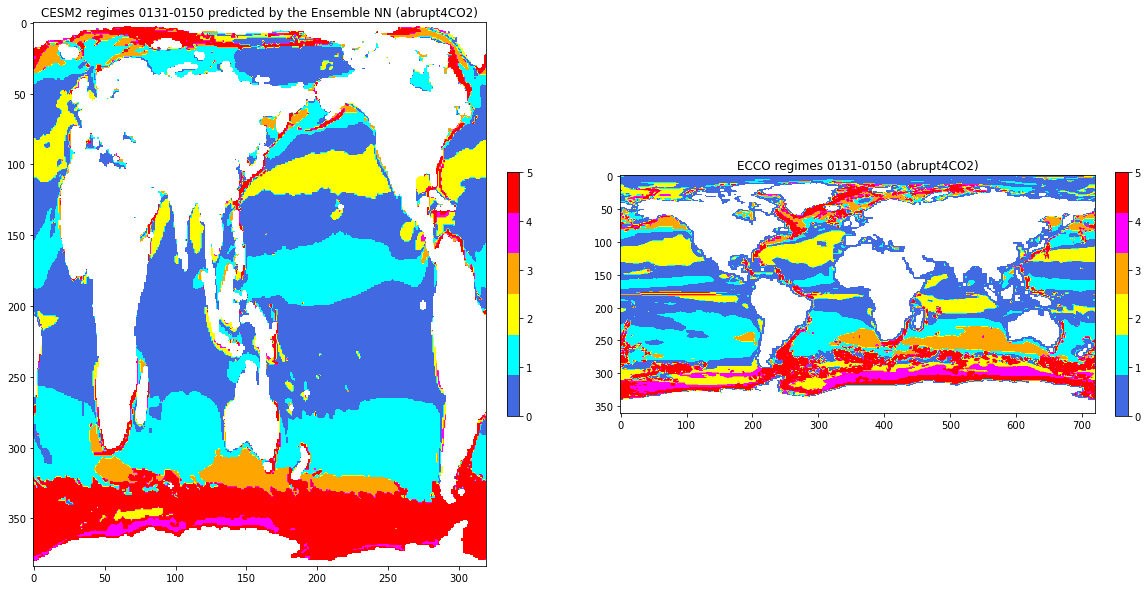

In [68]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.imshow(datapredicted_results_abrupt4CO2[-1,:,:][::-1,:], cmap=mycmap)
plt.colorbar(fraction=0.024, pad=0.04)
plt.title('CESM2 regimes 0131-0150 predicted by the Ensemble NN (abrupt4CO2)')

plt.subplot(1,2,2)
plt.imshow(ecco_label[::-1,:], cmap=mycmap)
plt.colorbar(fraction=0.024, pad=0.04)
plt.title('ECCO regimes 0131-0150 (abrupt4CO2)')

# Save the images for the 20 years chunks

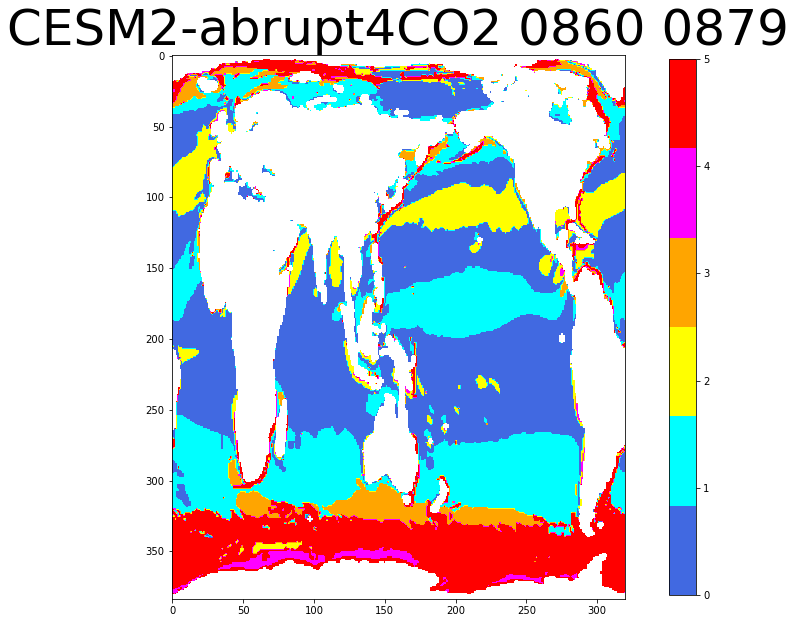

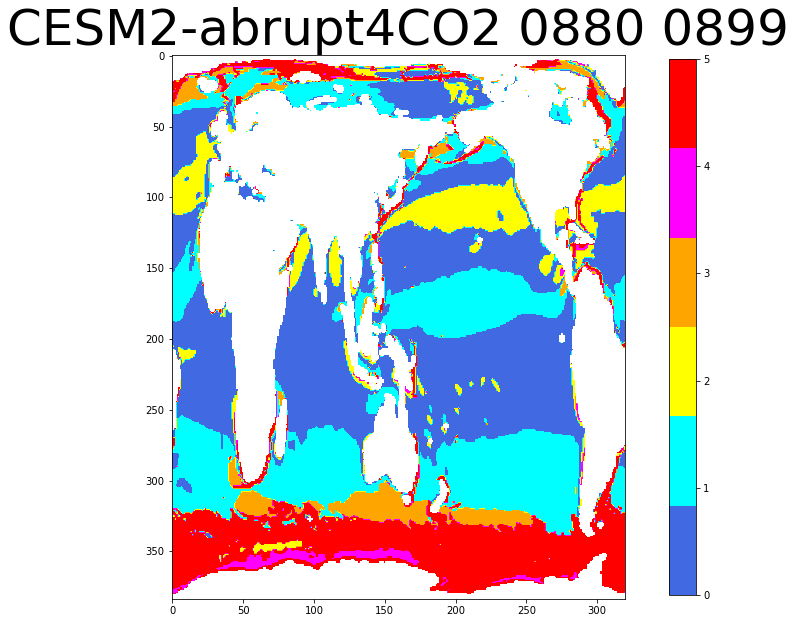

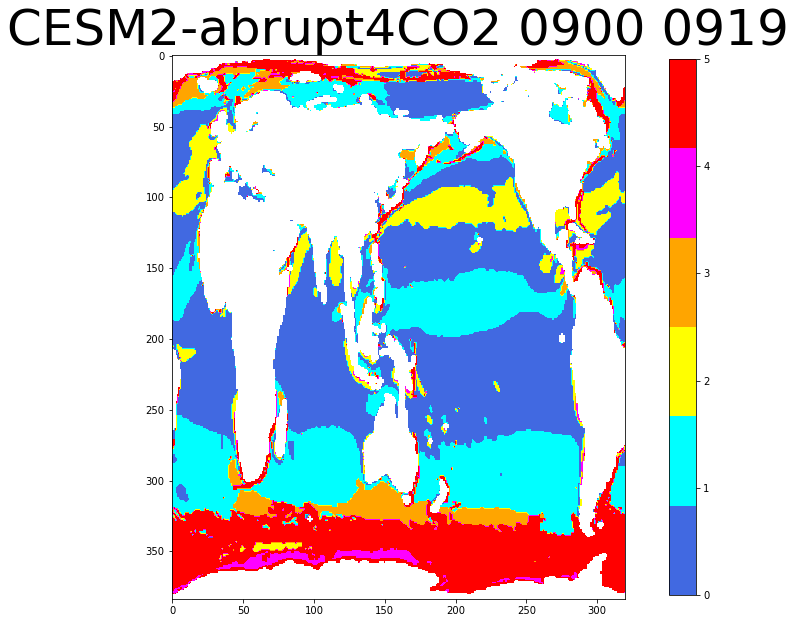

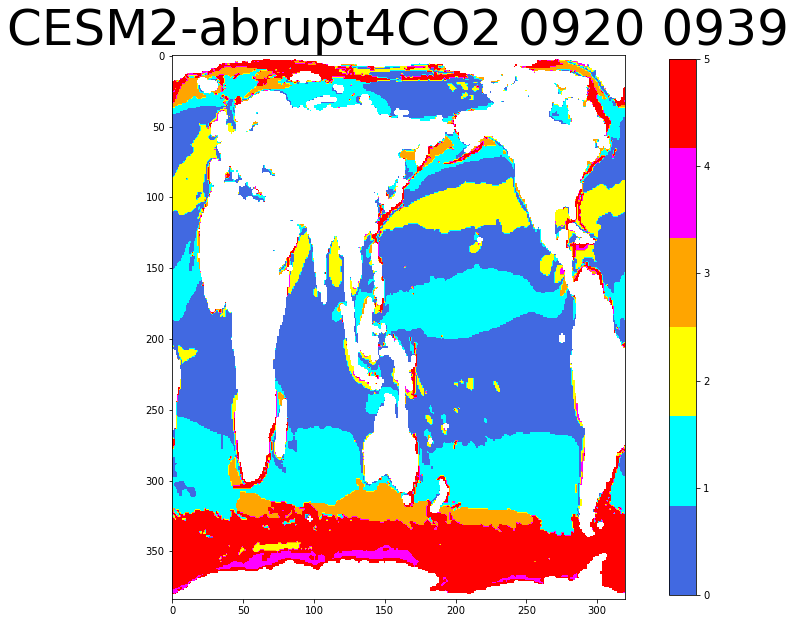

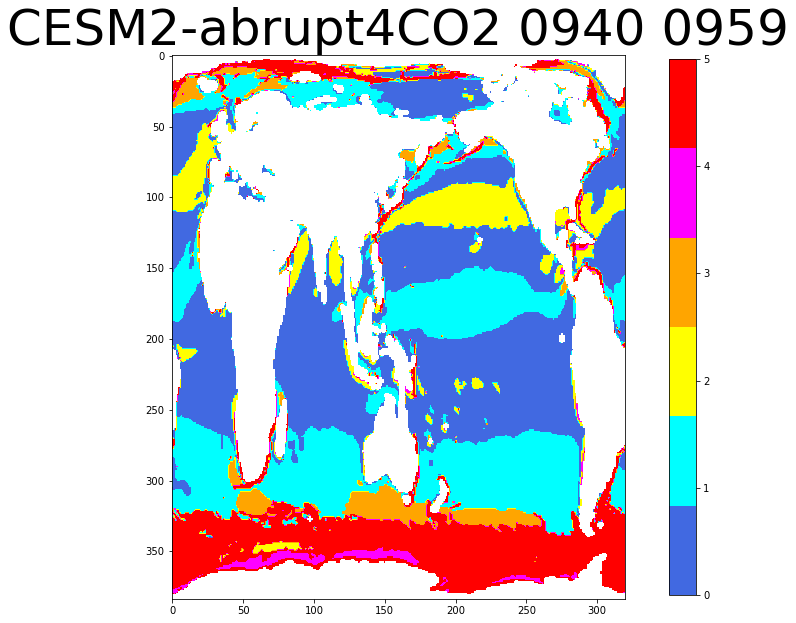

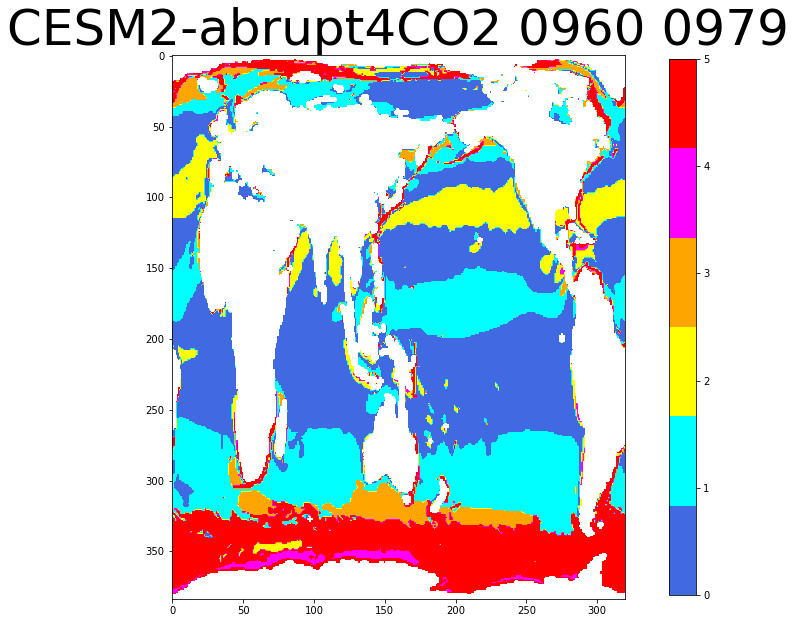

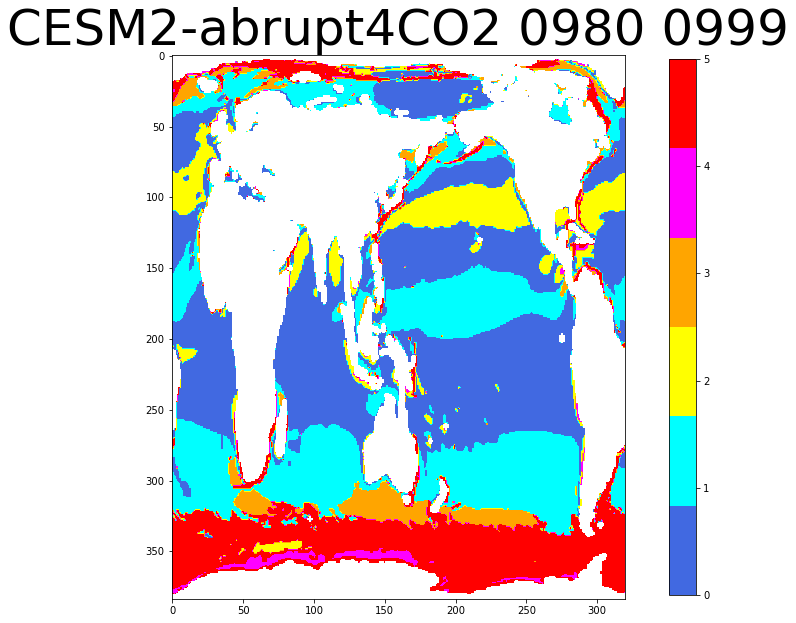

In [72]:
for i in range(7):
    plt.figure(figsize=(20,10))
    #plt.subplot(1,2,1)
    plt.imshow(datapredicted_results_abrupt4CO2[i,:,:][::-1,:], cmap=mycmap)
    plt.colorbar(fraction=0.024, pad=0.04)
    plt.title('CESM2-abrupt4CO2 '+str(listyears4abruptprct[2*i])+' '+str(listyears4abruptprct[2*i+1]), fontsize=50)
    plt.savefig('/home/jovyan/DNN4Cli/THOR/ApplicationOnCMIPModels/CESM2/png_abrupt4prctCO2_CESM2/'+str(listyears[2*i])+str(listyears[2*i+1])+'.png')

## create a gif

In [75]:
import os
import imageio

png_dir = 'png_abrupt4prctCO2_CESM2/'
images = []
for file_name in sorted(os.listdir(png_dir)):
    if file_name.endswith('.png'):
        file_path = os.path.join(png_dir, file_name)
        images.append(imageio.imread(file_path))
imageio.mimsave('png_abrupt4prctCO2_CESM2/png_abrupt4prctCO2_CESM2.gif', images, fps=1)